# Forward inference of sentiment prediction task using `fine-tuned XLM-roBERTa Hindi model`

## Installs and imports

In [ ]:
!pip install --upgrade pip
!pip install sentencepiece
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import AutoModelForSequenceClassification
from torch.utils.data import DataLoader
import torch
import numpy as np
from scipy.special import softmax
import pandas as pd

## Load the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [53]:
df = pd.read_csv (
    '/content/drive/My Drive/The-London-Story/CrowdTangle-TLS-workspace/2022-07-11-16-34-58-CEST-Historical-Report-2016-12-31--2022-07-11.csv',
    low_memory=False,  
    lineterminator='\n', 
    sep=';', 
    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)


In [54]:
df.shape

(604703, 40)

Because the size of the dataset is too large, let's choose first N values from the dataframe

In [55]:
df = df.head(50000)

In [56]:
df.columns

Index(['account.name', 'account.handle', 'platformId', 'Page Category',
       'Page Admin Top Country', 'Page Description', 'Page Created',
       'subscriberCount', 'Followers at Posting', 'date', 'Post Created Date',
       'Post Created Time', 'type', 'totalInteraction',
       'statistics.actual.likeCount', 'statistics.actual.commentCount',
       'statistics.actual.shareCount', 'statistics.actual.loveCount',
       'statistics.actual.wowCount', 'statistics.actual.hahaCount',
       'statistics.actual.sadCount', 'statistics.actual.angryCount',
       'statistics.actual.careCount', 'Video Share Status', 'Is Video Owner?',
       'statistics.actual.videoPostViewCount',
       'statistics.actual.videoTotalViewCount',
       'statistics.actual.videoAllCrosspostsViewCount', 'Video Length',
       'postUrl', 'message', 'expandedLinks.original',
       'expandedLinks.expanded', 'imageText', 'title', 'description',
       'brandedContentSponsor.platformId', 'brandedContentSponsor.name',
 

## Preprocess the dataset

Replace NaN values in particular columns with empty string

In [57]:
df.message = df.message.fillna('')
df.description = df.description.fillna('')
df.imageText = df.imageText.fillna('')

In [58]:
message_df = df ['message']
description_df = df ['description']
imageText_df = df ['imageText']

print ("Total number of entries in the message dataset:", len(message_df))
message_df.tail()

Total number of entries in the message dataset: 50000


49995    
49996    
49997    
49998    
49999    
Name: message, dtype: object

In [59]:
description_df.head()

0                                                     
1    बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...
2    बॉलीवुड के मशहूर अभिनेता अनिल कपूर एक ऐसे अभिन...
3    पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...
4    पेट्रोलियम कंपनियों ने रोज की तरह आज सुबह 6 बज...
Name: description, dtype: object

In [60]:
imageText_df.tail()

49995    पराज्वजन्य Panchjanya @epanchjanya ब्राह्मणों ...
49996    पराज्वजन्य Panchjanya @epanchjanya ब्राह्मणों ...
49997    पराज्वजन्य Panchjanya @epanchjanya ब्राह्मणों ...
49998    पराज्वजन्य Panchjanya @epanchjanya ब्राह्मणों ...
49999    पराज्वजन्य Panchjanya @epanchjanya ब्राह्मणों ...
Name: imageText, dtype: object

Convert dataframes to lists

In [61]:
message_list = message_df.tolist()
description_list = description_df.tolist()
imageText_list = imageText_df.tolist()

Drop empty strings

In [62]:
message_list = [x for x in message_list if x]
description_list = [x for x in description_list if x]
imageText_list = [x for x in imageText_list if x]

In [63]:
print ("Total number of text entries in the message list:", len(message_list))
print ("Total number of text entries in the description list:", len(description_list))
print ("Total number of text entries in the image text list:", len(imageText_list))

Total number of text entries in the message list: 31614
Total number of text entries in the description list: 28374
Total number of text entries in the image text list: 13417


## Load the model and the tokenizer

Declare parameters

In [67]:
CUDA = True # set to true if using GPU (Runtime -> Change runtime Type -> GPU)

BATCH_SIZE = 32

n_labels =3

labels_ids = {'negative': 0, 'neutral': 1, 'positive':2}

max_length = 312

MODEL_PATH = "/content/drive/MyDrive/The-London-Story/Supervised-NLP-tasks/Models/HI-model-89%/full_model.pt" # path to our fine-tuned model

Load model and the tokenizer

In [68]:
MODEL = torch.load (MODEL_PATH) 
model = MODEL.eval()

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-xlm-roberta-base", use_fast=True)

## Define the forward prediction function

In [ ]:
def forward(text, cuda=True):
  #text = preprocess(text)
  encoded_input = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length = 312)
  if cuda:
    encoded_input.to('cuda')
    output = model(**encoded_input)
    scores = output[0].detach().cpu().numpy()
  else:
    output = model(**encoded_input)
    scores = output[0].detach().numpy()
  
  scores = softmax(scores, axis=-1)
  return scores

## Run forward prediction

In [75]:
dl = DataLoader(message_list, batch_size=BATCH_SIZE)

all_preds = []

for idx, batch in enumerate(dl):
  print('Batch ',idx+1,' of ',len(dl))
  text = batch
  if (text != "nan"):
    scores = forward(text, cuda=CUDA)
    preds = np.argmax(scores, axis=-1)
    all_preds.extend(preds)

Batch  1  of  988
Batch  2  of  988
Batch  3  of  988
Batch  4  of  988
Batch  5  of  988
Batch  6  of  988
Batch  7  of  988
Batch  8  of  988
Batch  9  of  988
Batch  10  of  988
Batch  11  of  988
Batch  12  of  988
Batch  13  of  988
Batch  14  of  988
Batch  15  of  988
Batch  16  of  988
Batch  17  of  988
Batch  18  of  988
Batch  19  of  988
Batch  20  of  988
Batch  21  of  988
Batch  22  of  988
Batch  23  of  988
Batch  24  of  988
Batch  25  of  988
Batch  26  of  988
Batch  27  of  988
Batch  28  of  988
Batch  29  of  988
Batch  30  of  988
Batch  31  of  988
Batch  32  of  988
Batch  33  of  988
Batch  34  of  988
Batch  35  of  988
Batch  36  of  988
Batch  37  of  988
Batch  38  of  988
Batch  39  of  988
Batch  40  of  988
Batch  41  of  988
Batch  42  of  988
Batch  43  of  988
Batch  44  of  988
Batch  45  of  988
Batch  46  of  988
Batch  47  of  988
Batch  48  of  988
Batch  49  of  988
Batch  50  of  988
Batch  51  of  988
Batch  52  of  988
Batch  53  of  988
Ba

## Inspect and save the results 

Plot the histogram of predicted labels

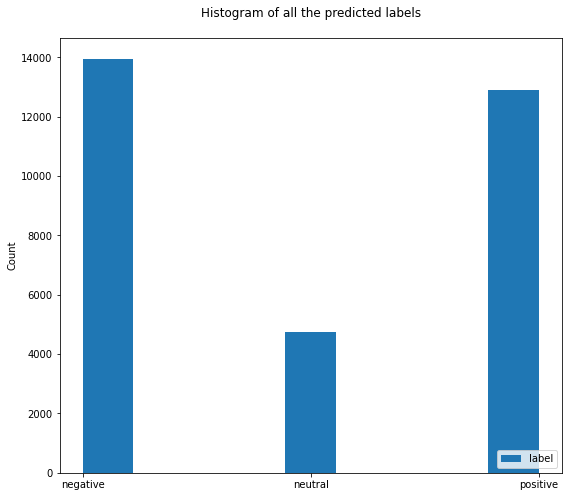

In [85]:
from matplotlib import pyplot as plt

x = np.arange(n_labels)
bins = np.linspace(0, 2, 10)

fig, ax = plt.subplots (figsize=(9, 8))
plt.title ('Histogram of all the predicted labels\n')
plt.hist ([all_preds], bins, label=['label'] )
ax.set_ylabel ('Count')
ax.set_xticks (x)
ax.set_xticklabels (list(labels_ids.keys()))
ax.legend (loc='lower right')
plt.show ()

Save the results into a dataframe and a csv

In [86]:
df_message_pred = pd.DataFrame()

#preds_list = ["negative" if i== 0 else "neutral" if i==1 else "positive" for i in all_preds]

df_message_pred ['message text']  = message_list
df_message_pred ['predicted label'] = all_preds

df_message_pred.to_csv('/content/drive/MyDrive/The-London-Story/Supervised-NLP-tasks/Results/CT_message_pred.csv', index=False)